In [16]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt

In [17]:
# Read Data
df = pd.read_csv('C:/Users/sweir/OneDrive/Desktop/Analysis Projects/Crude_Oil_Price_Projection/ML Resources/Cleaned_Crude_Oil_Dataset.csv')

# setting Date as index so that the model does not read it as data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date')


,"Cushing, OK Crude Oil Future Contract ($/Bar.)",U.S. Field Production of Crude Oil (1k Bar.),Product Supplied of Crude Oil and Petroleum Products (1k Bar.),Gross Inputs to Refineries (1k Bar./Day),Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day),Operating Crude Oil Distillation Capacity (1k Bar./Day),Idle Crude Oil Distillation Capacity (1k Bar./Day),Percent Utilization of Refinery Operable Capacity,"Cushing, OK WTI Spot Price FOB ($/Bar.)"
Date,,,,,,,,,
1986-01-01,23.0,283248,498728,12583,15459,14639,820,81.4,22.9
1986-02-01,15.5,256855,453209,12068,15485,14538,947,77.9,15.5
1986-03-01,12.6,279413,504565,11759,15485,14517,968,75.9,12.6
1986-04-01,12.8,265917,478339,12603,15473,14550,923,81.5,12.8
1986-05-01,15.3,273964,495789,13314,15484,14805,679,86.0,15.4
...,...,...,...,...,...,...,...,...,...
2021-06-01,71.4,338645,616115,16743,18128,17910,218,92.4,71.4
2021-07-01,72.4,351228,616714,16482,18129,17943,187,90.9,72.5
2021-08-01,67.7,347393,635828,16377,18130,17914,216,90.3,67.7


In [18]:
print(df.shape)
df.head()

(430, 10)


,Date,"Cushing, OK Crude Oil Future Contract ($/Bar.)",U.S. Field Production of Crude Oil (1k Bar.),Product Supplied of Crude Oil and Petroleum Products (1k Bar.),Gross Inputs to Refineries (1k Bar./Day),Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day),Operating Crude Oil Distillation Capacity (1k Bar./Day),Idle Crude Oil Distillation Capacity (1k Bar./Day),Percent Utilization of Refinery Operable Capacity,"Cushing, OK WTI Spot Price FOB ($/Bar.)"
0,1986-01-01,23.0,283248,498728,12583,15459,14639,820,81.4,22.9
1,1986-02-01,15.5,256855,453209,12068,15485,14538,947,77.9,15.5
2,1986-03-01,12.6,279413,504565,11759,15485,14517,968,75.9,12.6
3,1986-04-01,12.8,265917,478339,12603,15473,14550,923,81.5,12.8
4,1986-05-01,15.3,273964,495789,13314,15484,14805,679,86.0,15.4


<AxesSubplot:>

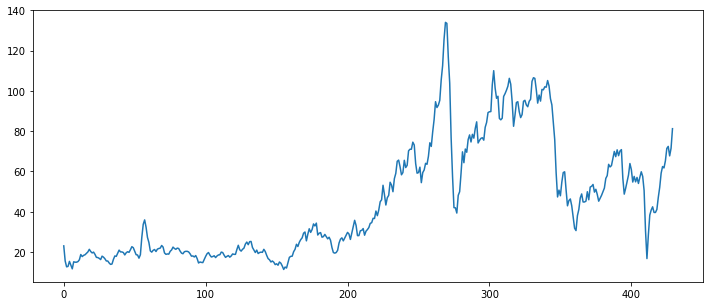

In [19]:
# Brief visualization: based on this, is our data stationary or not? 
df['Cushing, OK Crude Oil Future Contract ($/Bar.)'].plot(figsize=(12,5))

In [4]:
# Augmented Dickey-Fuller Test. Our Data doesn't appear stationary, but we should confirm.
def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Number Of Lags : ", dftest[2])
  print("4. Number Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [5]:
adf_test(df['Cushing, OK Crude Oil Future Contract ($/Bar.)'])

1. ADF :  -2.3512258637524353
2. P-Value :  0.1559781558165947
3. Number Of Lags :  1
4. Number Of Observations Used For ADF Regression and Critical Values Calculation : 428
5. Critical Values :
	 1% :  -3.445721386098794
	 5% :  -2.868316661451884
	 10% :  -2.5703797268320376


In [6]:
# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
# determining training and testing splits
print(df.shape)
train=df.iloc[:387]
test=df.iloc[387:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(430, 10)
(387, 10) (43, 10)
Date                                                               2018-04-01 00:00:00
Cushing, OK Crude Oil Future Contract ($/Bar.)                                    66.3
U.S. Field Production of Crude Oil (1k Bar.)                                    314803
Product Supplied of Crude Oil and Petroleum Products (1k Bar.)                  601151
Gross Inputs to Refineries (1k Bar./Day)                                         17101
Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day)                  18598
Operating Crude Oil Distillation Capacity (1k Bar./Day)                          18561
Idle Crude Oil Distillation Capacity (1k Bar./Day)                                  37
Percent Utilization of Refinery Operable Capacity                                 92.0
Cushing, OK WTI Spot Price FOB ($/Bar.)                                           66.3
Name: 387, dtype: object Date                                                               2021-10-0

In [8]:
# Determining order for ARIMA model using auto_arima
stepwise_fit = auto_arima(train['Cushing, OK Crude Oil Future Contract ($/Bar.)'], trace=True, 
                          suppress_warnings=True)           

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2146.145, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2214.430, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2153.849, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2167.979, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2212.660, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2153.480, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2154.965, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2147.203, Time=0.58 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2147.621, Time=0.46 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2155.039, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2149.719, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2145.362, Time=0.37 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2152.534, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2147.285, Time=0.47 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  387
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -1066.827
Date:                Tue, 08 Feb 2022   AIC                           2143.655
Time:                        22:02:38   BIC                           2163.434
Sample:                             0   HQIC                          2151.499
                                - 387                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2177      0.067     18.215      0.000       1.087       1.349
ar.L2         -0.2180      0.072     -3.026      0.002      -0.359      -0.077
ar.L3         -0.1418      0.039     -3.631      0.000      -0.218      -0.065
ma.L1         -0.8758      0.055    -15.844      0.000      -0.984      -0.767
sigma2        14.7131      0.717     20.527      0.000      13.308      16.118
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               153.34
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              12.52   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
# defining and fitting our ARIMA model to the training set
m = ARIMA(train['Cushing, OK Crude Oil Future Contract ($/Bar.)'],order=(3,1,1))
model = m.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            ARIMA Model Results                                             
============================================================================================================
Dep. Variable:     D.Cushing, OK Crude Oil Future Contract ($/Bar.)   No. Observations:                  386
Model:                                               ARIMA(3, 1, 1)   Log Likelihood               -1066.681
Method:                                                     css-mle   S.D. of innovations              3.834
Date:                                              Tue, 08 Feb 2022   AIC                           2145.362
Time:                                                      22:03:23   BIC                           2169.097
Sample:                                                           1   HQIC                          2154.774
                                                                                                            
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
const                                                      0.0926      0.169      0.547      0.584      -0.239       0.424
ar.L1.D.Cushing, OK Crude Oil Future Contract ($/Bar.)     1.2212      0.085     14.356      0.000       1.055       1.388
ar.L2.D.Cushing, OK Crude Oil Future Contract ($/Bar.)    -0.2198      0.086     -2.547      0.011      -0.389      -0.051
ar.L3.D.Cushing, OK Crude Oil Future Contract ($/Bar.)    -0.1412      0.054     -2.620      0.009      -0.247      -0.036
ma.L1.D.Cushing, OK Crude Oil Future Contract ($/Bar.)    -0.8804      0.072    -12.152      0.000      -1.022      -0.738
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2682           -0.3499j            1.3155           -0.0428
AR.2            1.2682           +0.3499j            1.3155            0.0428
AR.3           -4.0934           -0.0000j            4.0934           -0.5000
MA.1            1.1359           +0.0000j            1.1359            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:>

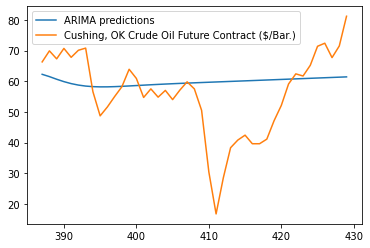

In [10]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred.plot(legend=True)
test['Cushing, OK Crude Oil Future Contract ($/Bar.)'].plot(legend=True)
plt.title('ARIMA Predictions vs. Actual WTI Futures Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')

<AxesSubplot:>

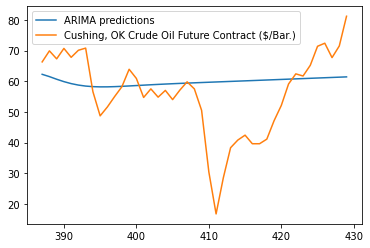

In [11]:
pred.plot(legend='ARIMA Predictions')
test['Cushing, OK Crude Oil Future Contract ($/Bar.)'].plot(legend=True)

In [ ]:
test['Cushing, OK Crude Oil Future Contract ($/Bar.)'].mean()

In [12]:
rmse=sqrt(mean_squared_error(pred,test['Cushing, OK Crude Oil Future Contract ($/Bar.)']))
print(rmse)

13.690194307816581


<AxesSubplot:>

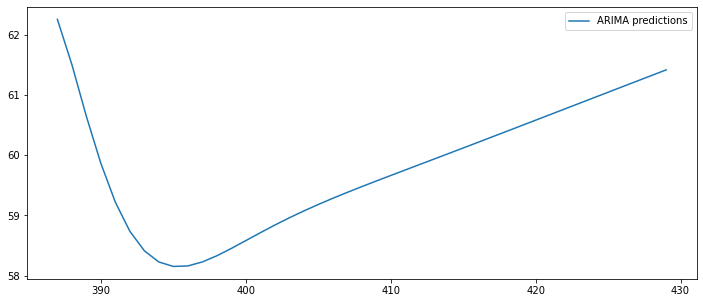

In [13]:
pred.plot(figsize=(12,5),legend=True)

13.690194307816581
